The objetcive of this script is to crrate a fraud-detection prediction model, where the output is 1 if the model classifies it as "guilty of fraud" and 0 if it doesn't

In [1]:
#!/usr/bin/python

import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tester import test_classifier, dump_classifier_and_data
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

salary                        51
to_messages                   60
deferral_payments            107
total_payments                21
loan_advances                142
bonus                         64
email_address                 35
restricted_stock_deferred    128
deferred_income               97
total_stock_value             20
expenses                      51
from_poi_to_this_person       60
exercised_stock_options       44
from_messages                 60
other                         53
from_this_person_to_poi       60
poi                            0
long_term_incentive           80
shared_receipt_with_poi       60
restricted_stock              36
director_fees                129
dtype: int64
Empty DataFrame
Columns: [salary, bonus, long_term_incentive, deferred_income, deferral_payments, loan_advances, other, expenses, director_fees, total_payments]
Index: []
Empty DataFrame
Columns: [exercised_stock_options, restricted_stock, restricted_stock_deferred, total_stock_value]
Index: [

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,144,144,144,144,144,144,144,144,144,144,144,144,144,144,144,144,144,144,144
mean,"185,446","1,239","222,801","2,149,476","582,812","675,997","-52,617","-194,395","3,017,427","36,356",39,"2,165,028",364,"293,788",25,"336,958",703,"905,016","9,712"
std,"197,042","2,238","753,841","8,779,364","6,794,472","1,233,155","273,183","605,842","6,271,528","45,990",74,"4,923,320","1,451","1,131,517",80,"687,183","1,077","2,000,357","30,423"
min,0,0,0,0,0,0,"-2,604,490","-3,504,386",0,0,0,0,0,0,0,0,0,0,0
25%,0,0,0,"87,472",0,0,0,"-39,072","256,376",0,0,0,0,0,0,0,0,"44,093",0
50%,"210,596",348,0,"913,825",0,"300,000",0,0,"980,534","21,937",4,"608,294",18,882,0,0,114,"361,978",0
75%,"269,668","1,623","8,536","1,885,158",0,"800,000",0,0,"2,372,703","54,234",41,"1,683,580",53,"148,577",14,"374,586",934,"857,103",0
max,"1,111,258","15,149","6,426,990","103,559,793","81,525,000","8,000,000",0,0,"49,110,078","228,763",528,"34,348,384","14,368","10,359,729",609,"5,145,434","5,521","14,761,694","125,034"


/Users/macbook/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


False    126
True      18
Name: poi, dtype: int64


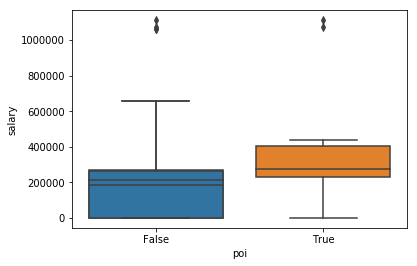

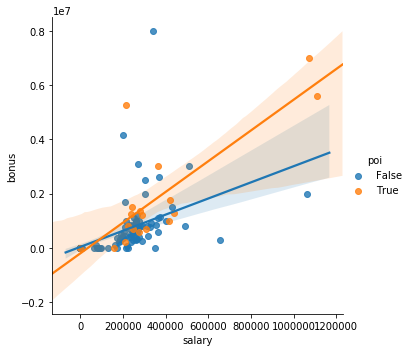

In [2]:
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi" since it is the label
features_list = ['poi','salary', 'bonus',"to_messages","deferral_payments", "total_payments","loan_advances","restricted_stock_deferred","deferred_income","total_stock_value","from_poi_to_this_person","exercised_stock_options","from_messages","from_this_person_to_poi","long_term_incentive","shared_receipt_with_poi","restricted_stock","director_fees"] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

#Let's create a DataFrame to visualize data
df = pd.DataFrame.from_dict(my_dataset, orient='index', dtype=None)


#We transfom NaN to Null values (since NaN is a string)
df = df.replace("NaN", np.nan)

pd.options.display.float_format = '{:10,.0f}'.format
df.describe()

#How many mising values do we have
num_missing_values = df.isnull().sum()
print(num_missing_values)


#Fill missing values with 0
df = df.fillna(0)
df.head()

payment_categories = ['salary', 'bonus', 'long_term_incentive', 'deferred_income',
                      'deferral_payments', 'loan_advances', 'other', 'expenses', 'director_fees', 'total_payments']
stock_value_categories = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']

# Look at the instances where the total we calculate is not equal to the total listed on the spreadsheet
df[df[payment_categories[:-1]].sum(axis='columns') != df['total_payments']][payment_categories]

df[df[stock_value_categories[:-1]].sum(axis='columns') != df['total_stock_value']][stock_value_categories]

#Some data has been shifted, let's order it

df.loc[('BELFER ROBERT','deferral_payments')] = 0
df.loc[('BELFER ROBERT','total_payments')] = 3285
df.loc[('BELFER ROBERT','restricted_stock_deferred')] = -44093
df.loc[('BELFER ROBERT','deferred_income')] = -102500
df.loc[('BELFER ROBERT','total_stock_value')] = 0
df.loc[('BELFER ROBERT','expenses')] = 3285
df.loc[('BELFER ROBERT','exercised_stock_options')] = 0
df.loc[('BELFER ROBERT','restricted_stock')] = 44093
df.loc[('BELFER ROBERT','director_fees')] = 102500

df.loc[('BHATNAGAR SANJAY','total_payments')] = 137864
df.loc[('BHATNAGAR SANJAY','restricted_stock_deferred')] = -2604490
df.loc[('BHATNAGAR SANJAY','total_stock_value')] = 15456290
df.loc[('BHATNAGAR SANJAY','expenses')] = 137864
df.loc[('BHATNAGAR SANJAY','exercised_stock_options')] = 15456290
df.loc[('BHATNAGAR SANJAY','other')] = 0
df.loc[('BHATNAGAR SANJAY','restricted_stock')] = 2604490
df.loc[('BHATNAGAR SANJAY','director_fees')] = 0

#Does that solve our problems ?
print(df[df[payment_categories[:-1]].sum(axis='columns') != df['total_payments']][payment_categories])
print(df[df[stock_value_categories[:-1]].sum(axis='columns') != df['total_stock_value']][stock_value_categories])

#Convert salary to float
df['salary'] = df['salary'].astype(float)

#droping rowS THAT WE DON'T NEED
df = df.drop("TOTAL")
df = df.drop("THE TRAVEL AGENCY IN THE PARK")

#The same for bonus
df['bonus'] = df['bonus'].astype(float)

#We drop columns that have the same value
to_drop = []
for column in df.columns:
    if len(pd.unique(df[column]))<2:
        to_drop.append(column)

df =df.drop(to_drop,axis=1)

#Description of the metrics
display(df.describe())
#Box plot of salary
display(sns.boxplot(y =df["salary"]))
#Box plot of Salary divided by POI
display(sns.boxplot(x="poi", y="salary", data=df))

#Simple linear Regression for bonus & salary
display(sns.lmplot(x="salary", y="bonus",hue="poi", data=df))

#How many POIs do we have ?
print(df["poi"].value_counts())

#If we want to use the cleaned data in other projects we can save it in a csv
clean_enron= "clean_enron_df_csv"
dirpath = os.getcwd()
df.to_csv(dirpath+clean_enron,index_label="name")

#we convert it back to dictionary
my_dataset = df.to_dict(orient="index")

### Extract features and labels from dataset for local testing
### We transform from dictionary to list ready for sklearn
data = featureFormat(my_dataset, features_list, sort_keys = True)

### We split the labels and features
labels, features = targetFeatureSplit(data)

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

#This allows to scale features, substracting the mean from each feature and then scaling it to unit cariance
from sklearn.preprocessing import StandardScaler
#Pipeline allows to do a sequence of different transformations in just one line
from sklearn.pipeline import Pipeline
#from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import decomposition
#We will use Grid Search to automatically tune the parameters of our model 

from sklearn.model_selection import GridSearchCV

#Let's separate the data in test. The train_test_split function splits arrays or matrices into random
#train and test subsets
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42,stratify=labels)

In [3]:
#First we will scale the data, then apply PCA to reduce dimensionality and then our classifier
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA()),
        ('clf', SVC(gamma='auto'))])
clf=SVC(gamma='auto')
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__C=np.logspace(-4, 1, 6),
                  clf__kernel=['rbf','linear'])


grid = GridSearchCV(pipe,param_grid=param_grid,cv=3, n_jobs=1, verbose=2, scoring="accuracy")

grid.fit(features_train, labels_train)

print("\n Best score %0.3f" % grid.best_score_)

print("\n Best parameters = ")
best_parameters = grid.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

grid.best_estimator_.score(features_train, labels_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dims__n_components=4 .....
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dims__n_components=4, total=   0.0s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dims__n_components=4 .....
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dims__n_components=4, total=   0.0s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dims__n_components=4 .....
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dims__n_components=4, total=   0.0s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dims__n_components=6 .....
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dims__n_components=6, total=   0.0s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dims__n_components=6 .....
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dims__n_components=6, total=   0.0s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dims__n_components=6 .....
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dims__n_components=6, total=   0.0s
[CV] clf__C=0.0001, clf__k

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  clf__C=0.001, clf__kernel=linear, reduce_dims__n_components=6, total=   0.0s
[CV] clf__C=0.001, clf__kernel=linear, reduce_dims__n_components=6 ...
[CV]  clf__C=0.001, clf__kernel=linear, reduce_dims__n_components=6, total=   0.0s
[CV] clf__C=0.001, clf__kernel=linear, reduce_dims__n_components=8 ...
[CV]  clf__C=0.001, clf__kernel=linear, reduce_dims__n_components=8, total=   0.0s
[CV] clf__C=0.001, clf__kernel=linear, reduce_dims__n_components=8 ...
[CV]  clf__C=0.001, clf__kernel=linear, reduce_dims__n_components=8, total=   0.0s
[CV] clf__C=0.001, clf__kernel=linear, reduce_dims__n_components=8 ...
[CV]  clf__C=0.001, clf__kernel=linear, reduce_dims__n_components=8, total=   0.0s
[CV] clf__C=0.01, clf__kernel=rbf, reduce_dims__n_components=4 .......
[CV]  clf__C=0.01, clf__kernel=rbf, reduce_dims__n_components=4, total=   0.0s
[CV] clf__C=0.01, clf__kernel=rbf, reduce_dims__n_components=4 .......
[CV]  clf__C=0.01, clf__kernel=rbf, reduce_dims__n_components=4, total=   0.0s
[

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.7s finished
/Users/macbook/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.87

In [4]:
#we make the predictions with the best estimator obtained by Grid Search
preds = grid.best_estimator_.predict(features_test)

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(labels_test,preds)))
print('Precision Score : ' + str(precision_score(labels_test,preds)))
print('Recall Score : ' + str(recall_score(labels_test,preds)))
print('F1 Score : ' + str(f1_score(labels_test,preds)))

#Dummy Classifier Confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix : \n' + str(confusion_matrix(labels_test,preds)))

Accuracy Score : 0.8837209302325582
Precision Score : 0.0
Recall Score : 0.0
F1 Score : 0.0
Confusion Matrix : 
[[38  0]
 [ 5  0]]


/Users/macbook/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbook/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
#Doesn't look good, since the algorithm predicts all our values to be 0a

In [ ]:
from sklearn.linear_model import LogisticRegression

grid_values = {
    "C":[ 65,75, 85], 
    "penalty":["l1","l2"]
}

clf =LogisticRegression()
grid = GridSearchCV(clf, grid_values, scoring='roc_auc', n_jobs=-1, verbose=10, cv=3)
grid.fit(features_train, labels_train)


print('Achieved score %f' % grid.best_score_, 'with params:', grid.best_params_)

In [ ]:
#we make the predictions with the best estimator obtained by Grid Search
preds = grid.best_estimator_.predict(features_test)

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(labels_test,preds)))
print('Precision Score : ' + str(precision_score(labels_test,preds)))
print('Recall Score : ' + str(recall_score(labels_test,preds)))
print('F1 Score : ' + str(f1_score(labels_test,preds)))

#Dummy Classifier Confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix : \n' + str(confusion_matrix(labels_test,preds)))

In [ ]:
test_classifier(clf, my_dataset, features_list)

In [ ]:
#dump_classifier_and_data(clf, my_dataset, features_list)